<a href="https://colab.research.google.com/github/hwarang97/Dacon/blob/main/competition/DACON_competition_%EB%8F%84%EB%B0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <참조 사이트>

albumentations 설명 : https://hoya012.github.io/blog/albumentation_tutorial/

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

# <추가학습. albumentations>

- torchvision.transforms를 대체하는 오픈 라이브러리
- 기존보다 속도가 훨씬 빠르고 더 많은 augmentation 기법들을 제공함

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':10,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':32,
    'SEED':41
}

In [ ]:
base_dir = "/content/drive/MyDrive/Colab Notebooks/data/open.zip (Unzipped Files)"
all_img_list = glob.glob(base_dir+'/train/*/*')
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split('/')[-2])

## <추가학습. train_test_split>

- arrays : data or data and label
    - data 만 넣을 경우 : train, test 로 분할
    - data and label  : x_train, x_test, y_train, y_test로 분할 (y가 label값)

- stratify : 각 클래스별로 분할 비율을 유지

In [ ]:
# 데이터셋을 0.8 / 0.2 비율로 나눔
train, val = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=CFG['SEED'])

In [ ]:
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'])
val['label'] = le.transform(val['label'])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [ ]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.HorizontalFlip(p=0.5),
                            A.RandomBrightnessContrast(p=0.5),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [ ]:
a_list = train['label'].value_counts()
class_counts = train['label'].value_counts().to_list()
class_weights = [1 / a_list[i] for i in range(len(class_counts))]
num_samples = sum(class_counts)
labels_lists = train['label'].to_list()
weights = [class_weights[labels_lists[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples), replacement=True)

In [ ]:
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], sampler=sampler, shuffle=False, num_workers=2)

val_dataset = CustomDataset(val['img_path'].values, val['label'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=2)

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b0(pretrained=True) #densenet161(pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha]*19)
        self.alpha[18] = 1-alpha
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * at

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
def trains(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
#     criterion = nn.CrossEntropyLoss(label_smoothing=0.1).to(device)
    criterion = FocalLoss(gamma=2, alpha=0.25)
    
    best_score = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
       
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
    
    return best_model

In [ ]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            pred = model(imgs)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')
    
    return _val_loss, _val_score

In [ ]:
model = BaseModel()

In [ ]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = trains(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.23231] Val Loss : [0.32015] Val Weighted F1 Score : [0.64043]


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.08756] Val Loss : [0.30823] Val Weighted F1 Score : [0.64249]


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.05642] Val Loss : [0.23103] Val Weighted F1 Score : [0.70674]


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.04234] Val Loss : [0.21541] Val Weighted F1 Score : [0.70426]


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.03681] Val Loss : [0.19579] Val Weighted F1 Score : [0.74964]


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.02653] Val Loss : [0.22289] Val Weighted F1 Score : [0.74454]


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.02531] Val Loss : [0.24224] Val Weighted F1 Score : [0.67263]


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.03703] Val Loss : [0.22773] Val Weighted F1 Score : [0.71460]
Epoch 00008: reducing learning rate of group 0 to 1.5000e-04.


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.02403] Val Loss : [0.19141] Val Weighted F1 Score : [0.75302]


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.01886] Val Loss : [0.17813] Val Weighted F1 Score : [0.76126]


In [ ]:
preds = []
true = []
inference_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=2)
with torch.no_grad() :
    for img, label in inference_loader :
        img = img.float().to(device)
        label = label.to(device)
        pred = infer_model(img)
        
        preds.extend(pred.argmax(1).detach().cpu().numpy())
        true.extend(label.detach().cpu().numpy().tolist())

In [ ]:
from sklearn.metrics import confusion_matrix

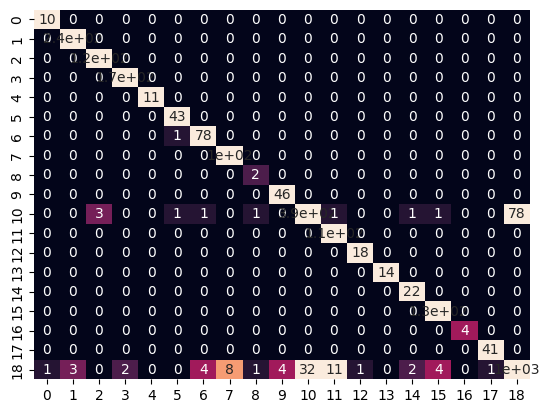

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(confusion_matrix(true, preds), annot=True, vmax = 10, vmin=0, cbar=False)
plt.show()

In [ ]:
train['pred'] = preds
train['true'] = true

In [ ]:
train.head()

,img_path,label,pred,true
2395,/content/drive/MyDrive/Colab Notebooks/data/op...,18,18,18
2475,/content/drive/MyDrive/Colab Notebooks/data/op...,18,18,18
2874,/content/drive/MyDrive/Colab Notebooks/data/op...,18,18,18
3265,/content/drive/MyDrive/Colab Notebooks/data/op...,18,10,18
1205,/content/drive/MyDrive/Colab Notebooks/data/op...,10,10,10


In [ ]:
train['err'] = train['pred'] == train['label']

In [ ]:
err_ds = train.loc[(train['err'] == False)].copy()

In [ ]:
img_err = err_ds['img_path'].values

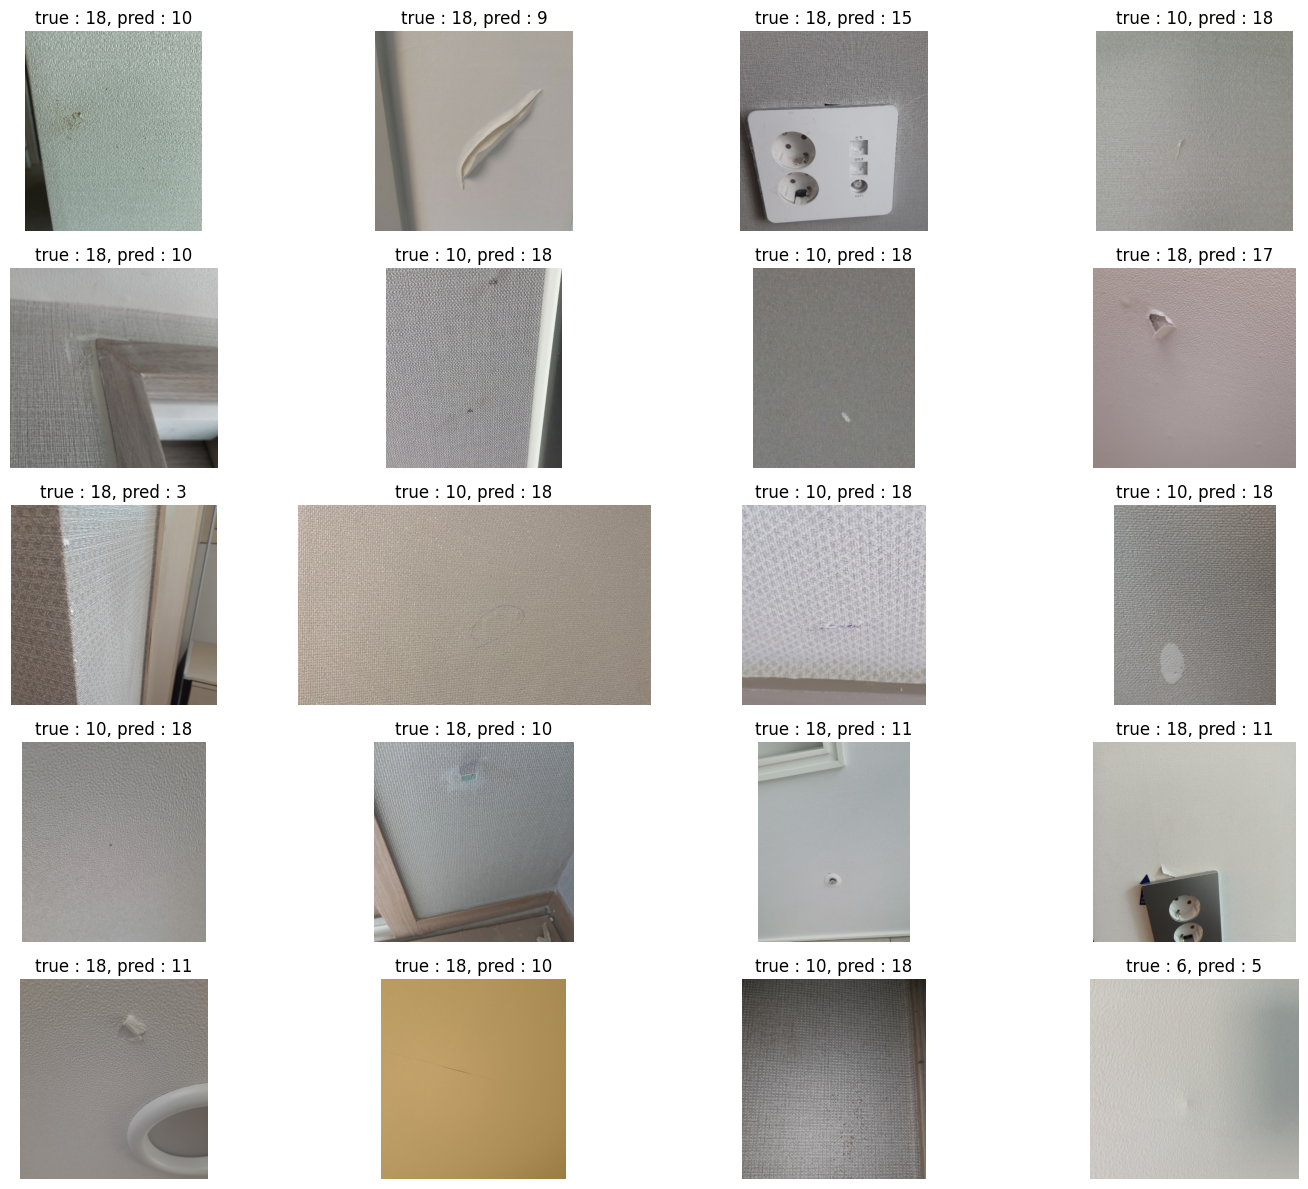

In [ ]:
plt.figure(figsize=(15,12))
for i in range(20):
    plt.subplot(5,4,i+1)
    im = Image.open(err_ds['img_path'].values[i])
    plt.imshow(im)
    plt.axis('off')
    tr = err_ds['label'].values[i]
    pr = err_ds['pred'].values[i]
    plt.title(f'true : {tr}, pred : {pr}')
plt.tight_layout()
plt.show()

In [ ]:
test = pd.read_csv(base_dir + '/test.csv')

In [ ]:
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=2)

In [ ]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(test_loader):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    preds = le.inverse_transform(preds)
    return preds

In [ ]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/25 [00:00<?, ?it/s]

TypeError: ignored

In [ ]:
submit = pd.read_csv(base_dir + '/sample_submission.csv')

In [ ]:
submit['label'] = preds

In [ ]:
submit.head()

In [ ]:
path = #경로지정
submit.to_csv(base_dir + path, index=False) 

In [ ]:
PATH = 'model.pickle'
torch.save(model.state_dict(), PATH)